# Fys245 Oblig 
### Johan Zapffe og Astrid Moum

grpgfsd


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import seaborn as sns
from matplotlib.animation import FuncAnimation

## Oppgave 1
Beregn transmissjonskoeffisienten til en partikkel beskrevet som en planbølge. 
Planbølgen har økende energier fra 20 eV.

Trinnpotensial med E > V0. Planbølge kommer inn fra venstre og treffer potensialtrinnet (Sett inn figur?)

In [ ]:
def T(E, V0):
    """
    Funksjon for å kalkulere transmissjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Transmissjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    transmitteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    T - ndarray
        1D numpy array av transmisjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    T = (4*k*k0)/(k+k0)**2
    
    return T

def R(E, V0):
    """
    Funksjon for å kalkulere refleksjonskoeffisienten til en partikkel beskrevet som en planbølge.
    Refleksjonskoeffisienten vil være i intervallet [0,1]. Dette beskriver prosentandelen av bølgen som
    reflekteres
    
    Inputs
    ------
    E - ndarray
        1D numpy array av energier til de innkommende planbølgene
    
    V0 - float
        Den potensielle energien til potensialtrinnet
    
    Returns
    -------
    R - ndarray
        1D numpy array av refleksjonskoeffisientene. I intervallet [0,1]
    
    """
    h_bar = 6.582 * 1e-16  # [eV*s]
    m = 9.11 * 1e-31  # mass of electron [kg]
    k = np.sqrt(2*m*E) / h_bar
    k0 = np.sqrt(2*m*(E-V0)) / h_bar
    R = (k - k0)**2/(k+k0)**2
    
    return R


# ===============================
# Beregner transmisjons- og refleksjonskoeffisienten for E=0.20 eV
# ===============================
E = 0.20  # eV
V0 = 0.16  # [eV]
T_coeff = T(E, V0)
R_coeff = R(E, V0)
R_coeff2 = 1-T_coeff  #ER DETTE NOK?

assert R_coeff.round(5) == R_coeff2.round(5), "The reflection coefficient should be equal whether \
                                                you calculate it by the formula R(E, V0) or  1-T"


print(f'Transmisjonskoeffisienten ved E={E} eV er {T_coeff.round(3)}. \nRefleksjonskoeffisienten ved E={E} er {R_coeff.round(3)}')

# ================================
# Energi høyere enn potensialet
# ================================
E = np.linspace(0.20, 2, 100)  # [eV]
V0 = 0.16  # [eV]

# Lager et plot av transmissjonskoeffisienten ved ulike verdier for energi
plt.plot(E, T(E,V0))
plt.title("Transmisjonskoeffisienten ved ulike energiverdier for planbølge")
plt.xlabel("E / [eV]", fontsize=12)
plt.show()

In [ ]:
# ============================
# Energi lavere enn potensialet
# ============================



## Oppgave 2


### Bølgepakken

In [9]:
sigma = 1* 1e-8  # [m]
#E = 0.20 * 1.602 * 1e-19 # [eV]
E = 0.20 * 1.602 * 1e-19 # [eV]
V0 = 0.16  * 1.602 * 1e-19 # [eV]
m = 9.11 * 1e-31  # [kg]
x0 = 50 * 1e-9  # [m]
L = 200 * 1e-9  # [m]
h_bar = 1.055 * 1e-34 # [eV*s]

t = 0
dt = 2.25 * 1e-19  # [s]
dx = 1.5 * 1e-10  # [m]

def V(x):
    """
    The potential energy of the particle. Will be infinite 
    
    Returns:
    --------
    float
        The potential energy of the particle   
    """
    inf=math.exp(15)
    
    V_list = []
    
    for xi in x:
        if xi <= 0 or xi >= L:
            V_list.append(inf)
        elif 0 < xi < L/2:
            V_list.append(0)
        else:
            V_list.append(V0)
    return V_list

def tidssteg_liste(t_slutt, dt):
    """
    Funksjon for å lage en liste av alle tidssteg
    """
    num_steps = int((t_slutt - dt)/dt)
    
    return np.linspace(dt, t_slutt, num_steps)

def Phi_neste_tidssteg(x, x0, t_slutt, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t_slutt - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    Phi_neste_tidssteg - npdarray
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    num_steps = int((t_slutt - dt)/dt)
    Phi_neste_tidssteg = np.zeros((num_steps, len(x)), dtype=complex)
    #Phi_neste_tidssteg = np.zeros((num_steps, len(x)))
    
    # Starter i t = \delta t. Den er avhengig av Phi(x, 0) - bølgepakken i t = 0. Denne er gitt ved likning 4 (manual) / 9 (vår likning)
    Phi_forrige_tidssteg = ksi(x, x0)
    
    for i, t in enumerate(tidssteg_liste(t_slutt, dt)):
    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. 
    
        Phi = f(Phi_forrige_tidssteg, x)
        Phi_neste_tidssteg[i] = Phi

        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
        Phi_forrige_tidssteg = Phi
    
    
    return Phi_neste_tidssteg

def Phi_neste_tidssteg2(x, x0, t_slutt, dt, dx):
    """
    Funksjon for å regne ut det neste tidssteget til den tidsavhengige bølgepakken
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
        
    t_slutt - float
        Tispunktet for forrige observerte bølgepakke
    
    dt - float
        Størrelsen på tidsintervallet vi observerer
    
    dx - float
        Størrelsen på posisjonsintervallet vi observerer
    
    Returns
    -------
    Phi_neste_tidssteg - npdarray
        bølgepakken for neste tidssteg
    
    See Also
    --------
    ksi(x, t)
        Den tidsavhengige bølgefunksjonen
    """
    num_steps = int((t_slutt - dt)/dt)

    for i, t in enumerate(tidssteg_liste(t_slutt, dt)):
    # For hvert tidssteg skal trinnpotensialet regnes ut for alle x. 
    
        Phi = f(Phi_forrige_tidssteg, x)
        Phi_neste_tidssteg[i] = Phi

        # Setter den utregnede verdien til Phi lik Phi_forrige_tidssteg for å gjøre klart for ny utregning av Phi
        Phi_forrige_tidssteg = Phi
    
    
    return Phi_neste_tidssteg

def fu(Phi_forrige_tidssteg, x):
    """
    Funksjon for å regne ut ny verdi av Phi som en funksjon av forrige verdi av Phi
    
    Inputs
    ------
    Phi_forrige_tidssteg - nparray
        Verdier for Phi ved forrige tidssteg
    
    Returns
    -------
    Phi - nparray
        Nye verdier for Phi
    """
    
    #pluss_dx = np.append(Phi_forrige_tidssteg[1:], [0])
    #minus_dx = np.append([0], Phi_forrige_tidssteg[:-1])
    
    # Regn ut den dobbeltderiverte kun for godkjente verdier
    pluss_dx = Phi_forrige_tidssteg[2:]
    minus_dx = Phi_forrige_tidssteg[:-2]
    scnd_d_x = (pluss_dx - 2*Phi_forrige_tidssteg[1:-1] + minus_dx) / dx**2  # Den andre deriverte av ksi mhp x
    
    # ==============
    # Regn ut Phi
    # ==============
    # Regner ut Phi, men ser bort ifra de ytterste verdiene ved Phi(0) og Phi(L)
    Phi = Phi_forrige_tidssteg[1:-1] + dt/(1j*h_bar) * ((-h_bar**2 * scnd_d_x/(2*m)) + Phi_forrige_tidssteg[1:-1] * V(x)[1:-1])
    
    # Setter Phi(0) og Phi(L) til 0
    Phi = np.append(Phi, 0)
    Phi = np.insert(Phi, 0, 0, axis=0)
    
    return  Phi


def ksi(x, x0):
    """
    Den stasjonære bølgepakken (tidsavhengig)
    
    Inputs
    ------
    x - nparray
        Posisjonen til bølgepakken (?)
    
    x0 - float
        Startpunktet for posisjonen til bølgepakken
    
    Returns
    -------
    float
        den stasjonære bølgepakken
    """
    k = np.sqrt(2*m*E) / h_bar
    return (1 / (np.pi**(1/4) * np.sqrt(sigma))) * np.exp(-((x-x0)**2 / (2*sigma**2)) + 1j*k*(x-x0))


def phi_i_andre(phi_array, x):
    """
    Funksjon for å beregne Phi^2, sannsynlighetsamplituden til Phi.
    
    Inputs
    ------
    phi_array - array
        array og phi values
    
    Returns
    -------
    phi_i_andre - array
        sannsynlighetsamplituden til bølgefunksjonen
    
    """
    phi_sqrd = phi_array * np.conjugate(phi_array)
    #num_steps = int((t_slutt - dt)/dt)
    #phi_sqrd = np.zeros((num_steps, len(x)), dtype=complex)
    #
    #for i, element in enumerate(phi_array):
    #    phi_sqrd[i] = element * np.conjugate(element)
    #    print(phi_sqrd[i])
    
    return phi_sqrd

def phi_i_andre2(phi):
    """
    Funksjon for å beregne Phi^2, sannsynlighetsamplituden til Phi.
    
    Inputs
    ------
    phi_array - array
        array og phi values
    
    Returns
    -------
    phi_i_andre - array
        sannsynlighetsamplituden til bølgefunksjonen
    
    """
    phi_sqrd = phi * np.conjugate(phi)
    #num_steps = int((t_slutt - dt)/dt)
    #phi_sqrd = np.zeros((num_steps, len(x)), dtype=complex)
    #
    #for i, element in enumerate(phi_array):
    #    phi_sqrd[i] = element * np.conjugate(element)
    #    print(phi_sqrd[i])
    
    return phi_sqrd


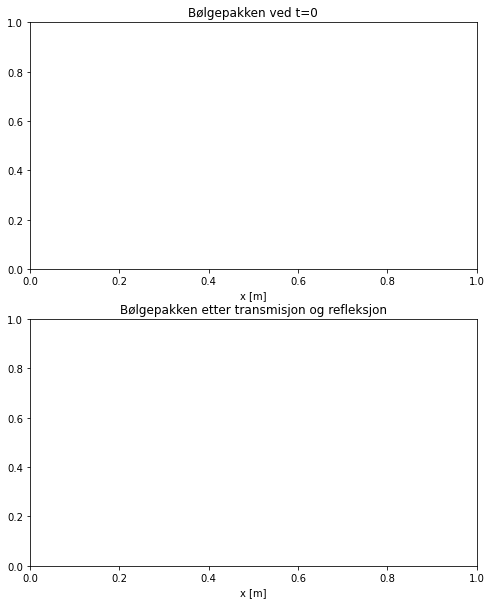

In [11]:
%matplotlib inline


#x = np.linspace(0, L, int(L/dx))
x = np.linspace(0, L, 1000)
#
#ff = ksi(x, x0)
#plt.plot(ff.imag)
#plt.show()

t_slutt = dt*1000000
#f3 = Phi_neste_tidssteg(x, x0, t_slutt, dt, dx)


num_t_steps = 2000000
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,10))
ax1.title.set_text('Bølgepakken ved t=0')
ax2.title.set_text('Bølgepakken etter transmisjon og refleksjon')

ax1.set_xlabel('x [m]')
ax2.set_xlabel('x [m]')

Phi_forrige_tidssteg = ksi(x, x0) 
saved_phi = []
saved_phi_sqrd = []

for i in range(num_t_steps):
    # Beregner sannsynlighetsamplituden
    phi_sqrd = phi_i_andre2(Phi_forrige_tidssteg)
    
    # Plotter hvert 10000 tidssteg
    if i % 10000 == 0:
        #print(Phi_neste_tidssteg[0:10])
        ## =================================
        ## Plotter bølgepakken
        ## =================================
        #ax1.plot(x, Phi_neste_tidssteg)
        #ax2.plot(x, Phi_neste_tidssteg)
        #plt.show()
        saved_phi.append(Phi_forrige_tidssteg)
        saved_phi_sqrd.append(phi_sqrd)
    
    # Bereger neste tidssteg
    Phi_neste_tidssteg = fu(Phi_forrige_tidssteg, x)
    
      
    Phi_forrige_tidssteg = Phi_neste_tidssteg


<IPython.core.display.Javascript object>


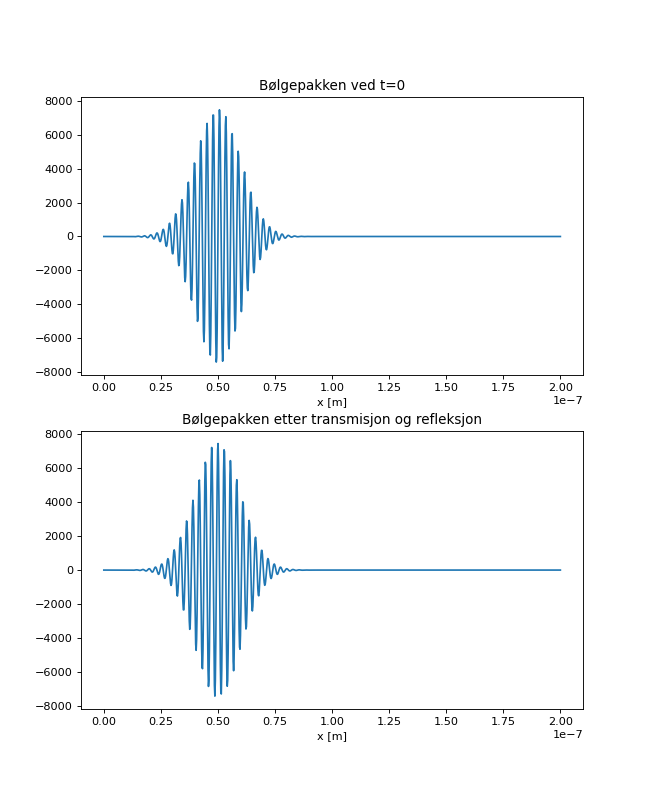

200


C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [53]:
# =================================
# Plotter bølgepakken
# =================================
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,10))
ax1.plot(x, saved_phi[0].imag)
ax2.plot(x, saved_phi[50])
#rint(saved_phi)
print(len(saved_phi))

ax1.title.set_text('Bølgepakken ved t=0')
ax2.title.set_text('Bølgepakken etter transmisjon og refleksjon')

ax1.set_xlabel('x [m]')
ax2.set_xlabel('x [m]')

plt.show()


<IPython.core.display.Javascript object>


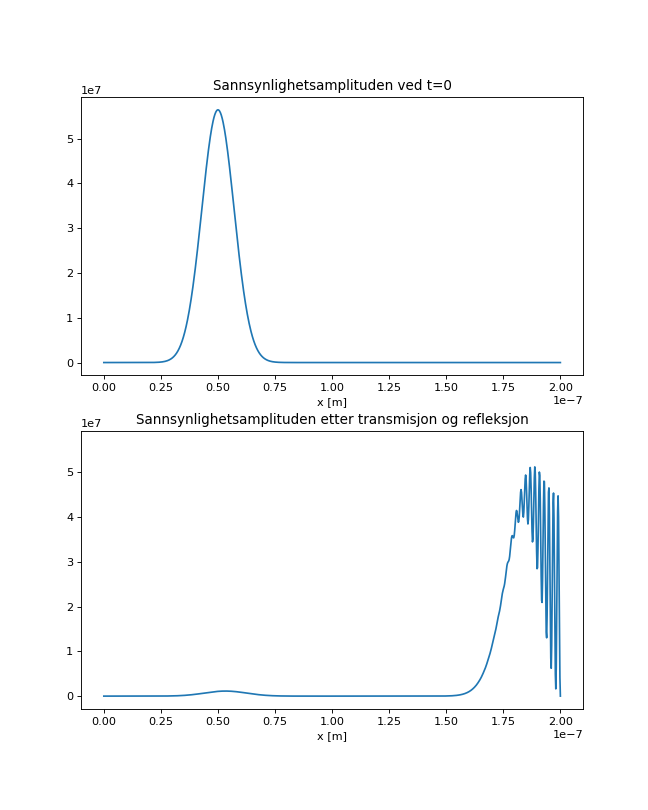

C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\astri\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [56]:
# ===================================
# Plotter sannsynlighetsamplituden
# ===================================

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,10))
ax1.plot(x, saved_phi_sqrd[0])
ax2.plot(x, saved_phi_sqrd[-1])

ax1.title.set_text('Sannsynlighetsamplituden ved t=0')
ax2.title.set_text('Sannsynlighetsamplituden etter transmisjon og refleksjon')

ax1.set_xlabel('x [m]')
ax2.set_xlabel('x [m]')

plt.show()


In [27]:
#print(saved_phi[0:10])
print(saved_phi[0])
print('hello')
print(saved_phi[-1])

[ 4.44754908e-03-2.76362558e-02j  1.79240015e-02-2.52103191e-02j
  3.00796494e-02-1.62086043e-02j  3.77041643e-02-1.34866733e-03j
  3.79761312e-02+1.70839787e-02j  2.92290844e-02+3.54461426e-02j
  1.16041249e-02+4.93215491e-02j -1.25937889e-02+5.44187208e-02j
 -3.89860281e-02+4.76317515e-02j -6.17306934e-02+2.80417580e-02j
 -7.46162831e-02-2.39617255e-03j -7.24764956e-02-3.87135135e-02j
 -5.26518628e-02-7.34856752e-02j -1.61548590e-02-9.80980530e-02j
  3.18049107e-02-1.04563360e-01j  8.21954863e-02-8.75665846e-02j
  1.23533557e-01-4.62917138e-02j  1.44127002e-01+1.44549584e-02j
  1.34828120e-01+8.42399019e-02j  9.17395817e-02+1.48345698e-01j
  1.82129571e-02+1.90414135e-01j -7.44836224e-02+1.96017402e-01j
 -1.68257288e-01+1.56487203e-01j -2.41132913e-01+7.21349950e-02j
 -2.71710510e-01-4.60301915e-02j -2.44370936e-01-1.76796464e-01j
 -1.54131859e-01-2.91775575e-01j -9.92359241e-03-3.60735718e-01j
  1.64807751e-01-3.58417762e-01j  3.34834951e-01-2.71496094e-01j
  4.59217060e-01-1.040506

In [49]:
#print(saved_phi_sqrd[0].real)

#uten_imag_phi_sqrd = saved_phi_sqrd[0:-1].real
for element in range(len(saved_phi_sqrd)):
    uten_imag_phi_sqrd = saved_phi_sqrd[element].real
print(uten_imag_phi_sqrd)

[0.00000000e+00 3.31982990e-02 1.27692130e-01 2.05018804e-01
 2.36124909e-01 2.14223158e-01 1.34255959e-01 6.94873852e-02
 6.02144223e-02 1.29273241e-01 2.42472121e-01 3.19661332e-01
 3.74059423e-01 3.50929465e-01 2.96725076e-01 2.70622561e-01
 3.00271925e-01 4.23514693e-01 5.48305979e-01 6.67607894e-01
 7.57112341e-01 7.64470707e-01 7.78317387e-01 8.12897648e-01
 9.44432427e-01 1.12378365e+00 1.32195265e+00 1.55181433e+00
 1.70593255e+00 1.83563735e+00 1.96886786e+00 2.17083752e+00
 2.48655150e+00 2.78859582e+00 3.20171852e+00 3.62463633e+00
 3.99597759e+00 4.40180074e+00 4.80407929e+00 5.40626778e+00
 6.02044852e+00 6.71247176e+00 7.57748757e+00 8.42138189e+00
 9.34162011e+00 1.02784504e+01 1.13771319e+01 1.26891837e+01
 1.40158135e+01 1.56530714e+01 1.73493020e+01 1.92530017e+01
 2.12367263e+01 2.33975652e+01 2.60225412e+01 2.86359006e+01
 3.17130319e+01 3.50974395e+01 3.87712311e+01 4.28259247e+01
 4.69982933e+01 5.19647990e+01 5.72257518e+01 6.29641832e+01
 6.93609357e+01 7.637294

<IPython.core.display.Javascript object>


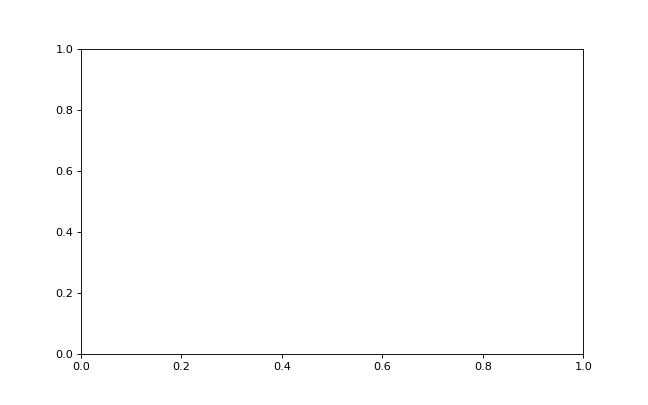

TypeError: list indices must be integers or slices, not tuple

In [59]:
# ==============================
# Lag animasjon av sannsynlighetsamplituden
# ==============================
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 5))
line = ax.plot(x, saved_phi_sqrd[0,:], lw=2, label=r"$|\Psi(x,t)|^2$")[0]
print(saved_phi_sqrd.shape)
tidssteg = tidssteg_liste(t_slutt, dt)

def animate(i):
    line.set_ydata(f32[i*500, :])

    ax.legend(fontsize=10, bbox_to_anchor=(.84, .97), ncol=1, framealpha=0)

anim = FuncAnimation(fig, animate, interval=15, frames=len(tidssteg)-1, repeat=True)
plt.show()

In [ ]:
# =================================
# Plotter bølgepakken
# =================================
#f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,10))
#ax1.plot(x, f3[0])
#ax2.plot(x, f3[-1000])
#
#ax1.title.set_text('Bølgepakken ved t=0')
#ax2.title.set_text('Bølgepakken etter transmisjon og refleksjon')
#
#ax1.set_xlabel('x [m]')
#ax2.set_xlabel('x [m]')
#
#plt.show()



In [ ]:
# ===================================
# Plotter sannsynlighetsamplituden
# ===================================

#f32 = phi_i_andre(f3, x)
#
#f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(8,10))
#ax1.plot(x, f32[0])
#ax2.plot(x, f32[-10000])
#
#ax1.title.set_text('Sannsynlighetsamplituden ved t=0')
#ax2.title.set_text('Sannsynlighetsamplituden etter transmisjon og refleksjon')
#
#ax1.set_xlabel('x [m]')
#ax2.set_xlabel('x [m]')
#
#plt.show()


In [ ]:
# ==============================
# Lag animasjon av sannsynlighetsamplituden
# ==============================
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 5))
line = ax.plot(x, f32[0,:], lw=2, label=r"$|\Psi(x,t)|^2$")[0]
print(f32.shape)
tidssteg = tidssteg_liste(t_slutt, dt)

def animate(i):
    line.set_ydata(f32[i*500, :])

    ax.legend(fontsize=10, bbox_to_anchor=(.84, .97), ncol=1, framealpha=0)

anim = FuncAnimation(fig, animate, interval=15, frames=len(tidssteg)-1, repeat=True)
plt.show()

In [ ]:
# =================================
# Beregner refleksjons- og transmisjonskoeffisient
# =================================

# Integrerer fra 100 til 200 nm
R = np.trapz(f32[-10000][0:(int(len(x)/2))], x[0:(int(len(x)/2))])
print('Sannsynligheten for refleksjon: ', R.real.round(3))

T = np.trapz(f32[-10000][(int(len(x)/2)):], x[(int(len(x)/2)):])
print('Sannsynligheten for transmisjon: ', T.real.round(3))

total_p = np.trapz(f32[-10000], x)
print('Total sannsynlighet (R+T): ', total_p.real.round(3))


## Oppgave 3
Undersøkelse av hvordan innfallsvinkel påvirker nnsynligheten for at elektroner blir transmittert.
Systemet blir beskrevet vha planbølge


Beregne T(E, alpha)

In [ ]:
V0 = 0.16  # [eV]
E = np.linspace(0.4, 0.2, 10)  # eV
alpha = np.linspace(0, 30, 10)  # degrees


#E = 0.2
#alpha = 0
m = 9.11 * 1e-31  # mass of electron [kg]
h_bar = 6.582 * 1e-16  # [eV*s]

In [ ]:
%matplotlib inline

def T(E, V0, alpha):
    """
    Funksjon for å beregne transmisjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen
    V0- float
        Den potensielle energien til potensialtrinnet
    alpha - float
        Innfallsvinkel til planbølgen
    
    Returns
    -------
    float
        Transmisjonskoeffisienten til planbølgen
    """
    T = np.zeros([len(E), len(alpha)])
    _alpha = np.deg2rad(alpha)
    
    for i, _E in enumerate(E):
        k = np.sqrt(2*m*_E) / h_bar  # likn 9
        k_y = k * np.sin(_alpha)  # likn 12
        k_x = k * np.cos(_alpha)
    
        k0_2 = 2*m*(_E-V0) / h_bar**2
        k0_x = np.sqrt(k0_2 - k_y**2)
        
        T[i] = 4 * k_x * k0_x / (k_x + k0_x) ** 2
    
    
    return T

def R(E, alpha):
    """
    Funksjon for å beregne refleksjonskoeffisienten avhengig av energien og
    og innfallsvinkelen til planbølgen. Vil være i intervallet [0,1]
    
    Inputs
    ------
    E - float
        Energi til planbølgen [eV]
    alpha - float
        Innfallsvinkel til planbølgen [grader]
    
    Returns
    -------
    float
        Refleksjonskoeffisienten til planbølgen
    """
    pass

# Regne ut transmisjonskoeffisienten for energi- og alpha-verdier
T_values = T(E, V0, alpha)

# Plotte transmisjonskoeffisienten
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=T_values, annot=True, fmt='.4g', xticklabels=alpha.round(2), yticklabels=E.round(2))
ax.set(xlabel=r'$\alpha [\degree]$', ylabel='Energy [eV]', title='Transmisjonskoeffisienten for planbølger med ulik energi og innfallsvinkel')
plt.show()

Når alpha har høy verdi (eks 30 grader) og energien til bølgepakken er lav (eks 0.2 eV) vil utregningen av k0_x gi
NaN. 
k0_x = np.sqrt(k0_2 - k_y ** 2)

Dette er fordi k0^2 - ky^2 < 0. Dermed får vi noe negativt under rottegn.

I praksis betyr dette at for tilstrekkelig høye vinklerer sannsynligheten for at partikkelen transmitteres lik 0. Det er dermed totalrefleksjon for disse vinklene


# SPØRSMÅL ONSDAG:
I praksis så vil det si at alt reflekteres og ingenting transmitteres(?). Teoretisk sett, hva vil det si at vi får et komplekst tall for transmisjonskoeffisienten?

Hvem har skrevet teksten til obligen?? (mtp kilde)